# Conv

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

conv = nn.Conv1d(1, 1, 3, bias=False)
x = torch.randn(1, 1, 7)
print("X:", x)
x = conv(x)
print("Conv Weight: ", conv.weight)
print("X:", x)

X: tensor([[[ 0.6271, -0.8328,  0.8553, -0.0753,  0.0563, -0.2524,  0.2964]]])
Conv Weight:  Parameter containing:
tensor([[[0.4174, 0.4150, 0.0334]]], requires_grad=True)
X: tensor([[[-0.0552,  0.0048,  0.3277, -0.0165, -0.0714]]],
       grad_fn=<SqueezeBackward1>)


## Understanding Padding 

In [3]:
conv = nn.Conv1d(1,1,3,padding=2,bias=False)
conv.weight

Parameter containing:
tensor([[[-0.5381, -0.3856,  0.0830]]], requires_grad=True)

In [4]:
sample = torch.randn(1,1,7)
sample

tensor([[[-1.1943,  0.4244,  0.5744, -0.9578, -1.0634,  1.1002,  1.1417]]])

In [5]:
from torch.autograd import Variable
conv(Variable(sample))

tensor([[[-0.0991,  0.4958,  0.5267, -0.5294, -0.0280,  1.0168,  0.2427,
          -1.0323, -0.6144]]], grad_fn=<SqueezeBackward1>)

# Pooling

In [6]:
import torch
import torch.nn as nn
import torch.autograd.variable as v

x = torch.randn(2, 2, 3)
print("Before Max:", x)

pool = nn.MaxPool2d(2, 2, 1)
x = pool(x)
print("After Maxpol:", x)

x = torch.randn(2, 2, 3)
print("Before AVG:", x)
avg = nn.AvgPool2d(2,2,1)
x = avg(x)
print("After AVG:", x)

Before Max: tensor([[[-0.2370,  0.0204, -0.8603],
         [ 1.0518, -0.0291,  0.3085]],

        [[-0.4475, -0.3909, -0.9166],
         [ 0.8231, -0.0869,  1.4698]]])
After Maxpol: tensor([[[-0.2370,  0.0204],
         [ 1.0518,  0.3085]],

        [[-0.4475, -0.3909],
         [ 0.8231,  1.4698]]])
Before AVG: tensor([[[ 0.1618,  0.6742, -0.3503],
         [-0.0352,  0.8492, -0.5047]],

        [[-0.6277, -0.3882,  1.4131],
         [-0.6720, -0.4237,  1.5230]]])
After AVG: tensor([[[ 0.0404,  0.0810],
         [-0.0088,  0.0861]],

        [[-0.1569,  0.2562],
         [-0.1680,  0.2748]]])


# Relu

In [7]:
relu = nn.ReLU(inplace=True)
print("Before RELU:", x)
x = relu(x)
print("After RELU:", x)

Before RELU: tensor([[[ 0.0404,  0.0810],
         [-0.0088,  0.0861]],

        [[-0.1569,  0.2562],
         [-0.1680,  0.2748]]])
After RELU: tensor([[[0.0404, 0.0810],
         [0.0000, 0.0861]],

        [[0.0000, 0.2562],
         [0.0000, 0.2748]]])


# Flatten

In [8]:
print("Before flatten:", x)
print("Shape: ", x.shape)
x = x.view(1, -1)
print("After flatten: ", x)
print("Shape: ", x.shape)

Before flatten: tensor([[[0.0404, 0.0810],
         [0.0000, 0.0861]],

        [[0.0000, 0.2562],
         [0.0000, 0.2748]]])
Shape:  torch.Size([2, 2, 2])
After flatten:  tensor([[0.0404, 0.0810, 0.0000, 0.0861, 0.0000, 0.2562, 0.0000, 0.2748]])
Shape:  torch.Size([1, 8])


# Deep drive in CNN with cats and dogs 

In [1]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
import time
%matplotlib inline

In [2]:

def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
   

## Check if GPU is present

In [3]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

## Load data into PyTorch tensors

In [4]:
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train = ImageFolder('dogsandcats/train/',simple_transform)
valid = ImageFolder('dogsandcats/valid/',simple_transform)

In [5]:
print(train.class_to_idx)
print(train.classes) 


{'cat': 0, 'dog': 1}
['cat', 'dog']


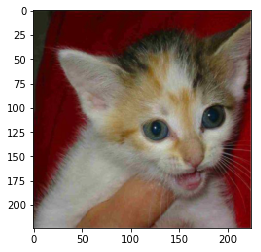

In [6]:
imshow(valid[770][0])

## Create data generators

In [7]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=32,num_workers=3,shuffle=True)

In [28]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(56180, 500)
        self.fc2 = nn.Linear(500,50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x,training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

In [29]:
model = Net()
if is_cuda:
    model.cuda()

In [30]:
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

In [31]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [32]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.67 and training accuracy is 13370/23000     58.13
validation loss is  0.63 and validation accuracy is 1298/2000      64.9
training loss is  0.62 and training accuracy is 15151/23000     65.87
validation loss is  0.58 and validation accuracy is 1386/2000      69.3
training loss is  0.59 and training accuracy is 15658/23000     68.08
validation loss is  0.56 and validation accuracy is 1416/2000      70.8
training loss is  0.57 and training accuracy is 16219/23000     70.52
validation loss is  0.53 and validation accuracy is 1465/2000     73.25
training loss is  0.53 and training accuracy is 16832/23000     73.18
validation loss is  0.51 and validation accuracy is 1504/2000      75.2
training loss is   0.5 and training accuracy is 17450/23000     75.87
validation loss is   0.5 and validation accuracy is 1506/2000      75.3
training loss is  0.47 and training accuracy is 17881/23000     77.74
validation loss is   0.5 and validation accuracy is 1505/2000     75.25
traini

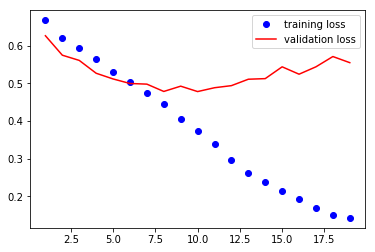

In [33]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

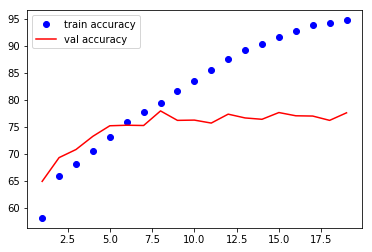

In [34]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

## Transfer learning using VGG

In [35]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()

### Print VGG

In [15]:
vgg

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

## Freeze layers

In [36]:
vgg.classifier[6].out_features = 2
for param in vgg.features.parameters(): param.requires_grad = False


In [37]:
optimizer = optim.SGD(vgg.classifier.parameters(),lr=0.0001,momentum=0.5)

In [38]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [39]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is   3.2 and training accuracy is 13714/23000     59.63
validation loss is  0.22 and validation accuracy is 1901/2000     95.05
training loss is  0.17 and training accuracy is 21928/23000     95.34
validation loss is 0.099 and validation accuracy is 1944/2000      97.2
training loss is  0.11 and training accuracy is 22246/23000     96.72
validation loss is 0.076 and validation accuracy is 1955/2000     97.75
training loss is  0.09 and training accuracy is 22368/23000     97.25
validation loss is 0.066 and validation accuracy is 1960/2000      98.0
training loss is 0.078 and training accuracy is 22412/23000     97.44
validation loss is  0.06 and validation accuracy is 1961/2000     98.05
training loss is 0.069 and training accuracy is 22470/23000      97.7
validation loss is 0.056 and validation accuracy is 1961/2000     98.05
training loss is 0.066 and training accuracy is 22514/23000     97.89
validation loss is 0.053 and validation accuracy is 1961/2000     98.05
traini

### Adjusting dropout

In [40]:
for layer in vgg.classifier.children():
    if(type(layer) == nn.Dropout):
        layer.p = 0.2

In [41]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,3):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 0.045 and training accuracy is 22655/23000      98.5
validation loss is 0.047 and validation accuracy is 1967/2000     98.35
training loss is 0.044 and training accuracy is 22664/23000     98.54
validation loss is 0.046 and validation accuracy is 1966/2000      98.3


### Data augmentation

In [42]:
train_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.RandomHorizontalFlip()
                                       ,transforms.RandomRotation(0.2)
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train = ImageFolder('dogsandcats/train/',train_transform)
valid = ImageFolder('dogsandcats/valid/',simple_transform)

In [43]:
train_data_loader = DataLoader(train,batch_size=32,num_workers=3,shuffle=True)
valid_data_loader = DataLoader(valid,batch_size=32,num_workers=3,shuffle=True)

In [44]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,3):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 0.044 and training accuracy is 22653/23000     98.49
validation loss is 0.045 and validation accuracy is 1969/2000     98.45
training loss is 0.043 and training accuracy is 22667/23000     98.55
validation loss is 0.044 and validation accuracy is 1970/2000      98.5


## Calculating preconvoluted features


In [46]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()

In [47]:
features = vgg.features

In [48]:
for param in features.parameters(): param.requires_grad = False


In [49]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=False)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=32,num_workers=3,shuffle=False)

In [50]:
def preconvfeat(dataset,model):
    conv_features = []
    labels_list = []
    for data in dataset:
        inputs,labels = data
        if is_cuda:
            inputs , labels = inputs.cuda(),labels.cuda()       
        inputs , labels = Variable(inputs),Variable(labels)
        output = model(inputs)
        conv_features.extend(output.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    
    return (conv_features,labels_list)

In [51]:
conv_feat_train,labels_train = preconvfeat(train_data_loader,features)

In [52]:
conv_feat_val,labels_val = preconvfeat(valid_data_loader,features)

In [53]:
class My_dataset(Dataset):
    def __init__(self,feat,labels):
        self.conv_feat = feat
        self.labels = labels
    
    def __len__(self):
        return len(self.conv_feat)
    
    def __getitem__(self,idx):
        return self.conv_feat[idx],self.labels[idx]

In [54]:
train_feat_dataset = My_dataset(conv_feat_train,labels_train)
val_feat_dataset = My_dataset(conv_feat_val,labels_val)

In [55]:
train_feat_loader = DataLoader(train_feat_dataset,batch_size=64,shuffle=True)
val_feat_loader = DataLoader(val_feat_dataset,batch_size=64,shuffle=True)

In [56]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

In [57]:
train_batches = data_gen(conv_feat_train,labels_train)
val_batches = data_gen(conv_feat_val,labels_val)

In [58]:
optimizer = optim.SGD(vgg.classifier.parameters(),lr=0.0001,momentum=0.5)

In [59]:
def fit_numpy(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        data = data.view(data.size(0), -1)
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [60]:
%%time
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit_numpy(epoch,vgg.classifier,train_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit_numpy(epoch,vgg.classifier,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is   5.9 and training accuracy is 6856/23000     29.81
validation loss is   1.1 and validation accuracy is 1607/2000     80.35
training loss is  0.47 and training accuracy is 20571/23000     89.44
validation loss is  0.22 and validation accuracy is 1902/2000      95.1
training loss is  0.19 and training accuracy is 21805/23000      94.8
validation loss is  0.13 and validation accuracy is 1934/2000      96.7
training loss is  0.14 and training accuracy is 22086/23000     96.03
validation loss is   0.1 and validation accuracy is 1944/2000      97.2
training loss is  0.12 and training accuracy is 22181/23000     96.44
validation loss is 0.085 and validation accuracy is 1950/2000      97.5
training loss is   0.1 and training accuracy is 22306/23000     96.98
validation loss is 0.076 and validation accuracy is 1955/2000     97.75
training loss is 0.093 and training accuracy is 22317/23000     97.03
validation loss is  0.07 and validation accuracy is 1957/2000     97.85
trainin

## Visualizing intermediate CNN layers

In [61]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=False)
img,label = next(iter(train_data_loader))

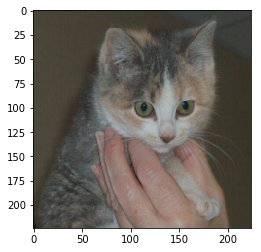

In [62]:
imshow(img[5])

In [63]:
img = img[5][None]

In [64]:
vgg = models.vgg16(pretrained=True).cuda()

In [65]:
class LayerActivations():
    features=None
    
    def __init__(self,model,layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        self.features = output.cpu().data.numpy()
    
    def remove(self):
        self.hook.remove()
        

conv_out = LayerActivations(vgg.features,0)

o = vgg(Variable(img.cuda()))

conv_out.remove()

In [66]:
act = conv_out.features

In [67]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(act[0][i])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [68]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

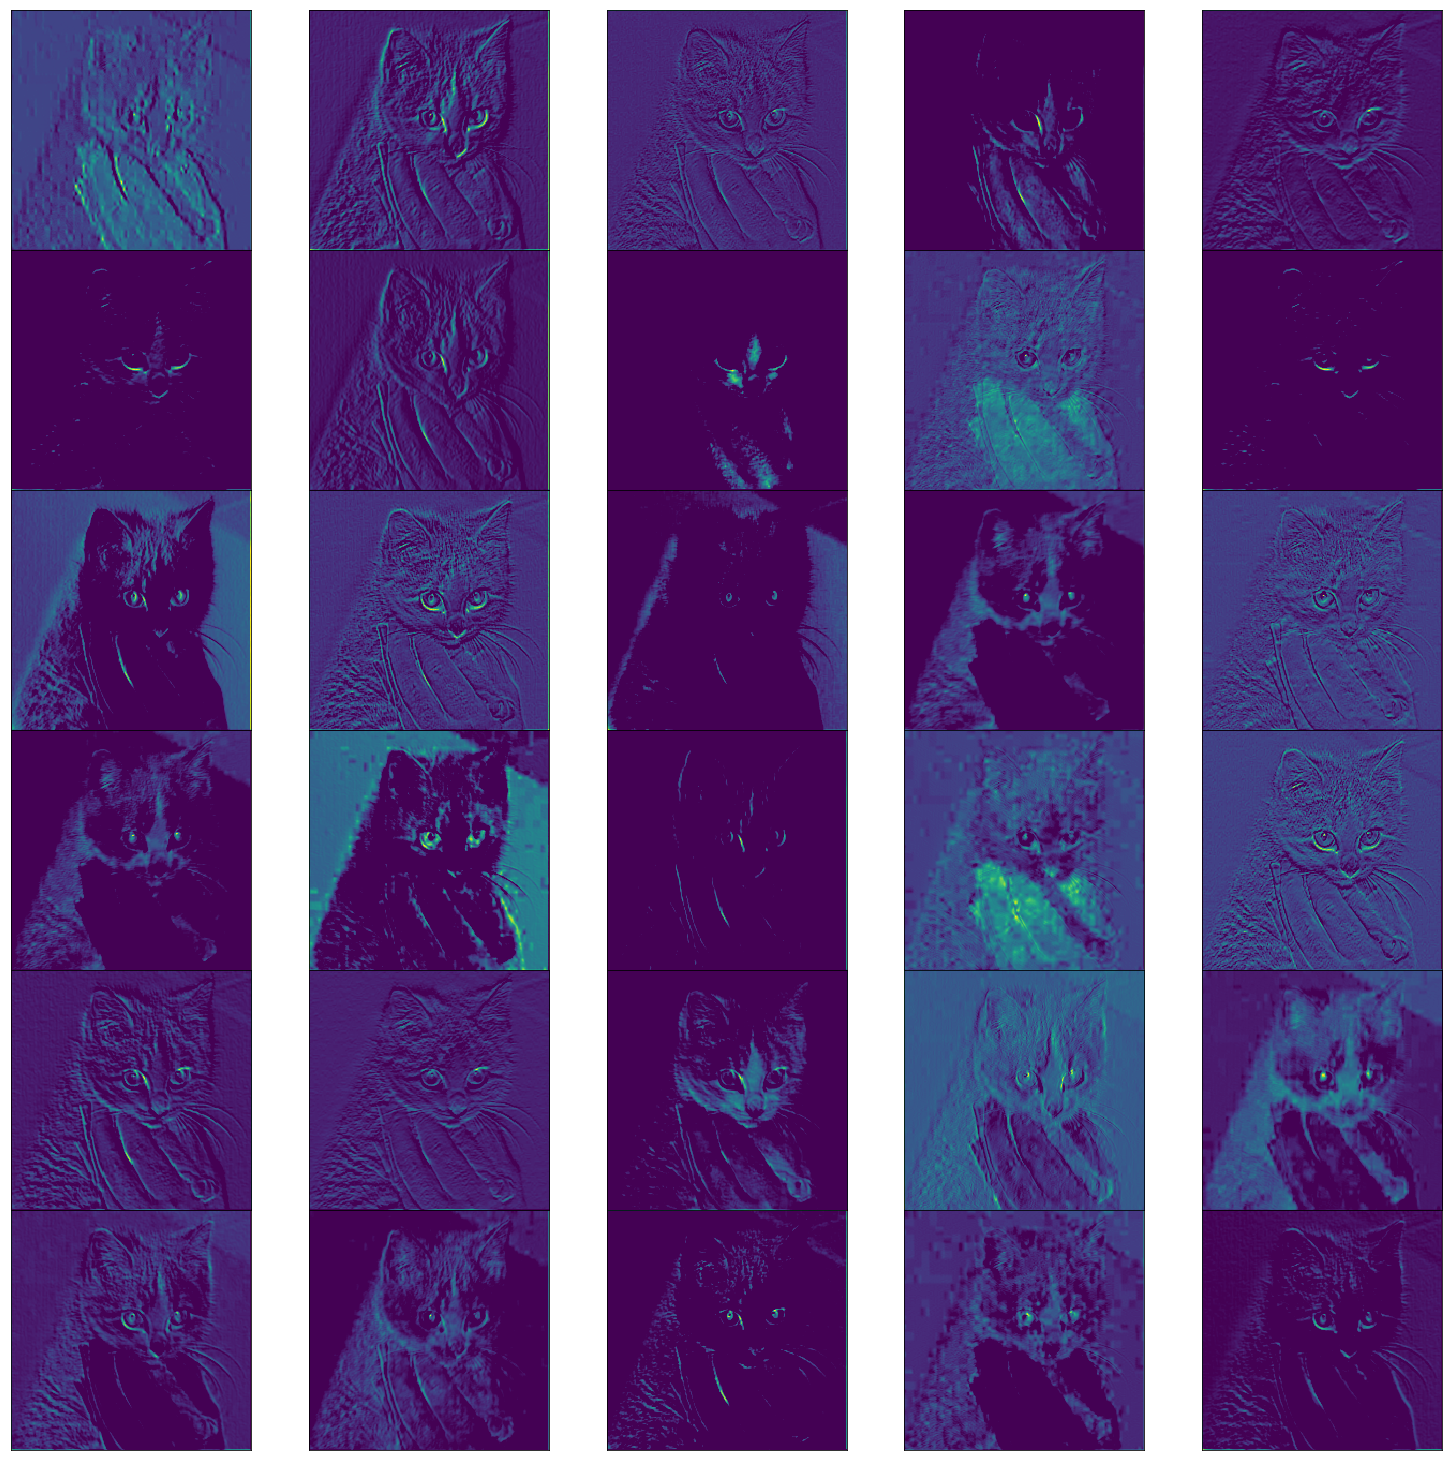

In [69]:
conv_out = LayerActivations(vgg.features,1)

o = vgg(Variable(img.cuda()))

conv_out.remove()

act = conv_out.features

fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(act[0][i])

In [70]:
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

In [71]:
conv_out = LayerActivations(vgg.features,1)

o = vgg(Variable(img.cuda()))

conv_out.remove()

act = conv_out.features

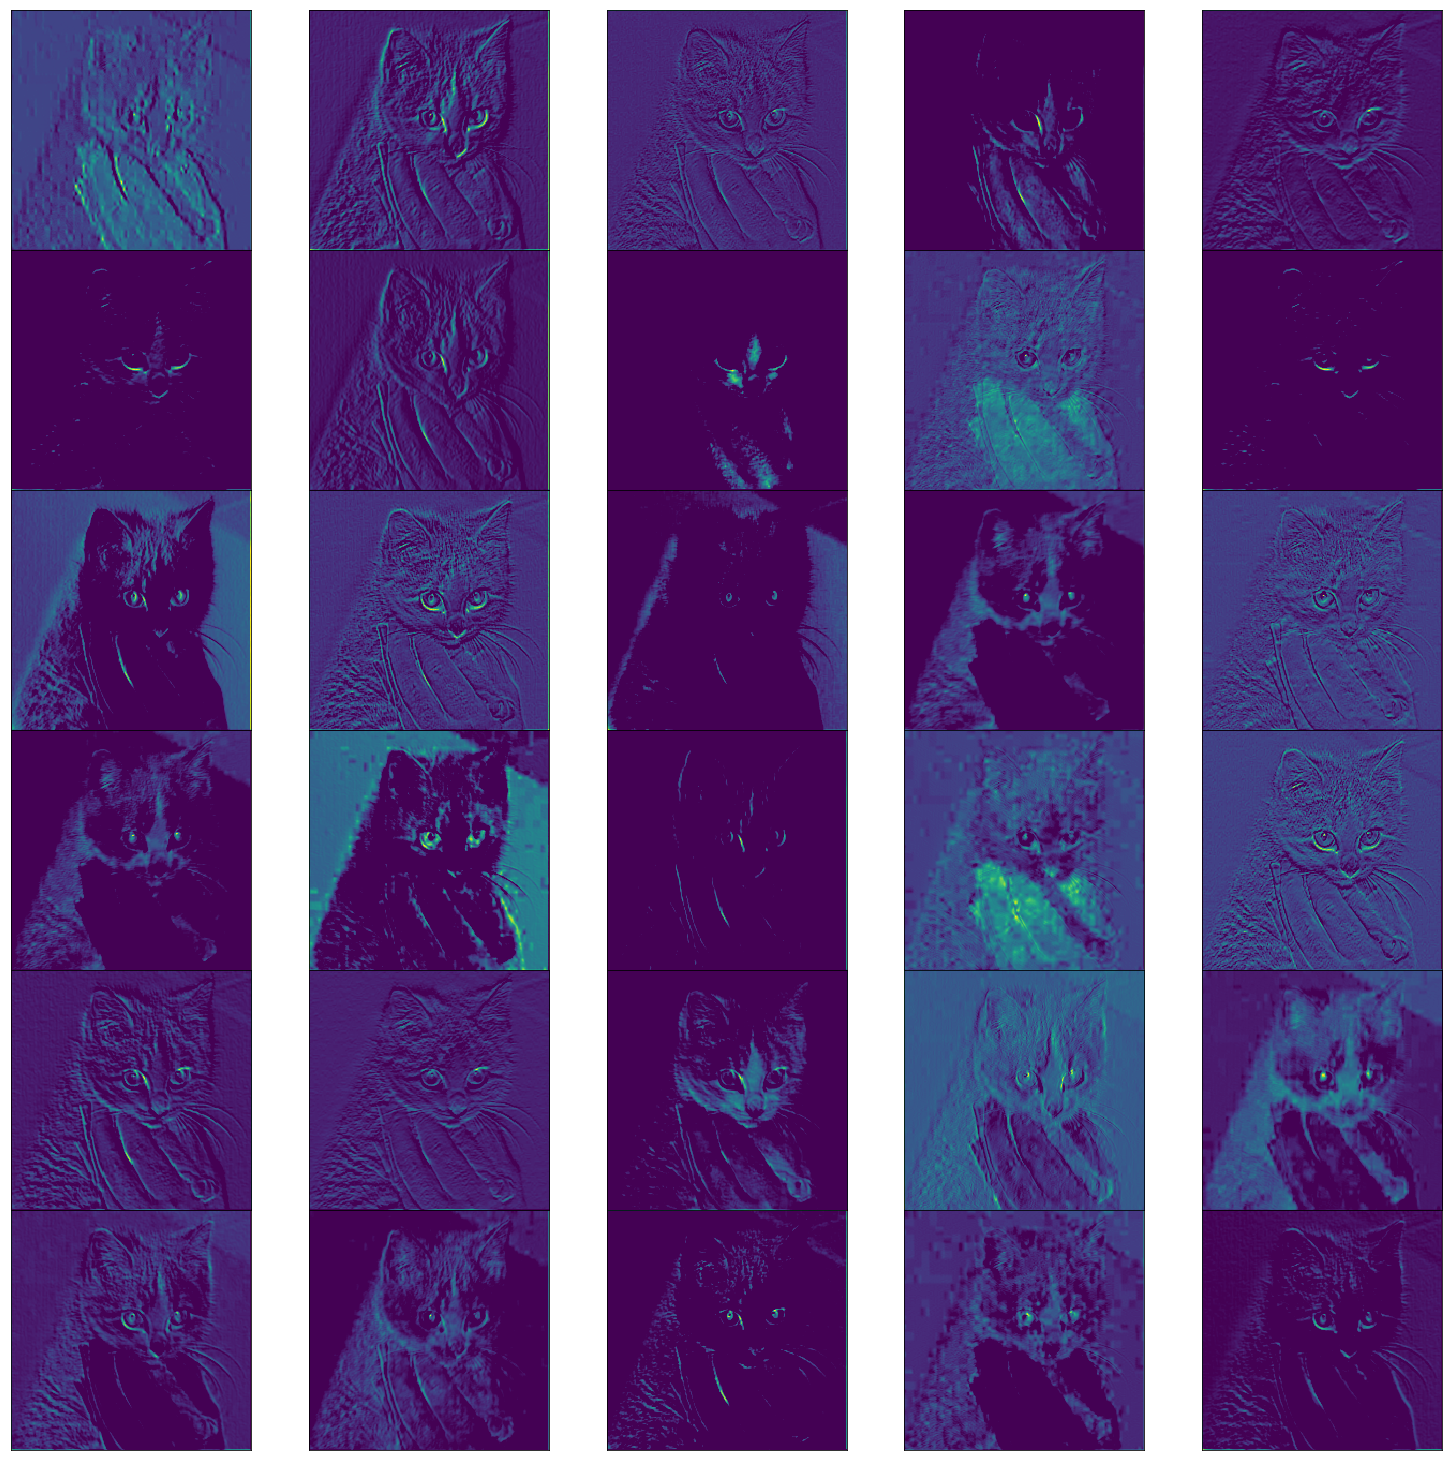

In [72]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(act[0][i])

## Visualizing weights

In [73]:
vgg = models.vgg16(pretrained=True).cuda()

In [74]:
vgg.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [75]:

cnn_weights = vgg.state_dict()['features.0.weight'].cpu()

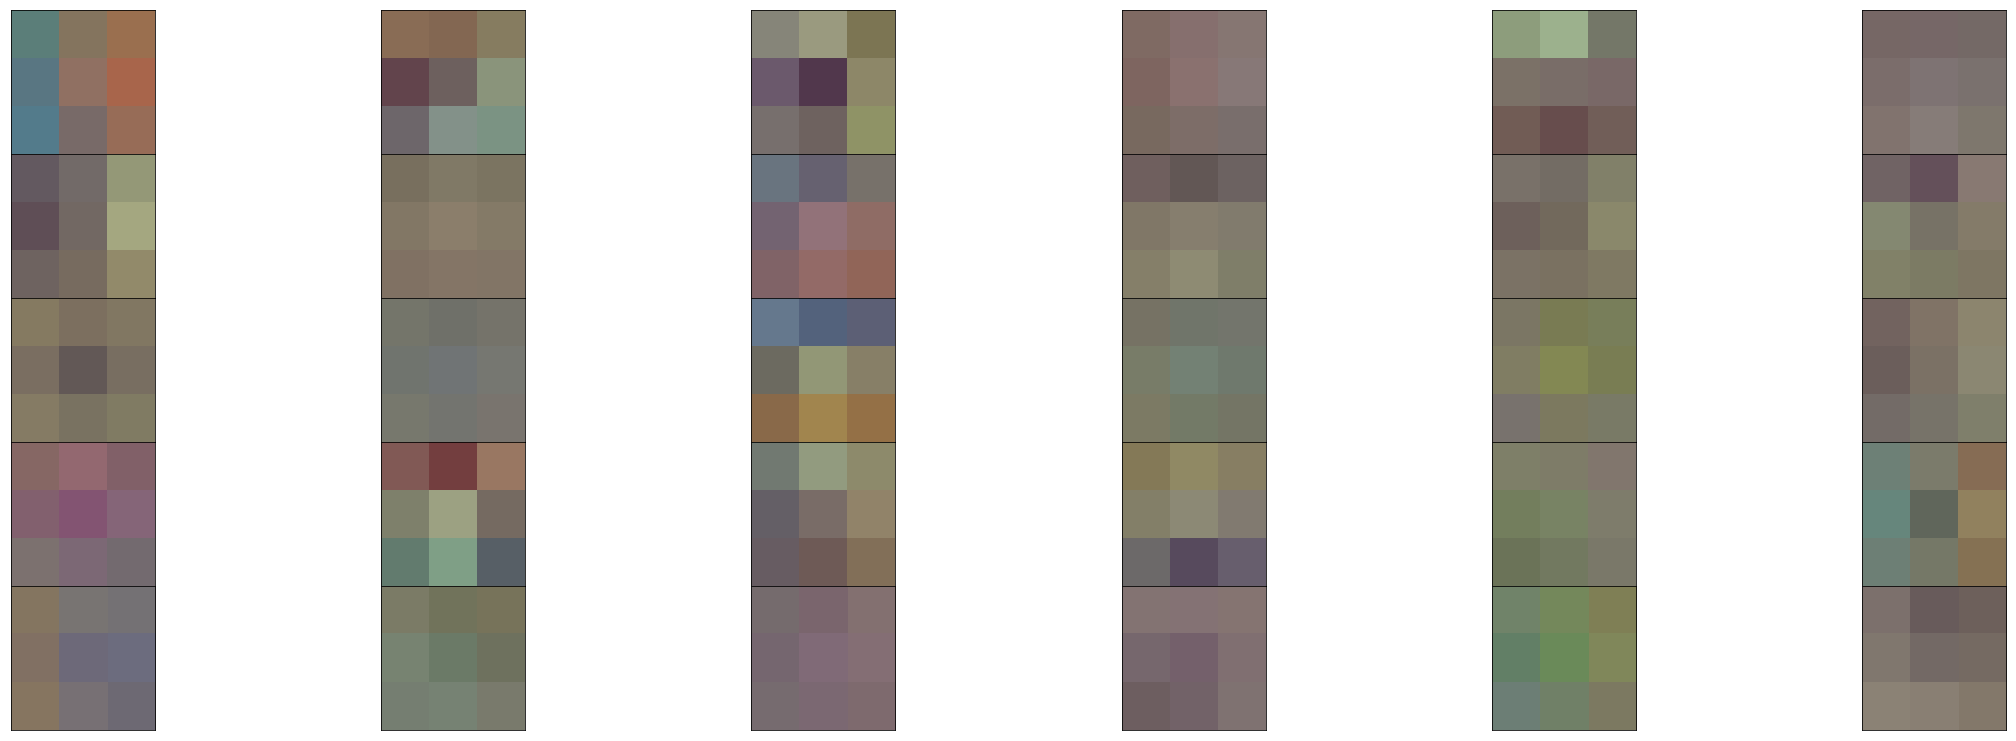

In [76]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,6,i+1,xticks=[],yticks=[])
    imshow(cnn_weights[i])

In [77]:
cnn_weights.shape

torch.Size([64, 3, 3, 3])